# Tutorial 01 - Data Loading & Preprocessing for RF Signal Classification

**by Markus Parrish**  
*updated: 2025-11-2*

---

## Project Overview
This project presents the development and evaluation of machine learning models for identification of radio frequency (RF) signals by focusing on Automatic Modulation Classification (AMC). The tutorial presents baseline models will include k-Nearest Neighbors (kNN), Support Vector Machines (SVM), and Random Forests. Deep learning methods will include Convolutional Neural Networks (CNNs), Recurrent Neural Networks (RNNs), and combinations of the prior. The dataset will be RadioML 2016.01A to enable a comparison across Signal-To-Noise Ratio (SNR) levels. It will provide reproducible code and highlight the limitations and benefits of each method.

This notebook steps through the data preparation and visualization steps that feed into the classical and deeplearning models.

- **Dataset:** RadioML 2016.10A  
- **Objective:** Compare performance across varying Signal-to-Noise Ratio (SNR) levels and highlight the benefits and limitations of each method.  



## Learning Objectives

- Understand the problem context and dataset.
- Set up the Python environment reproducibly.
- Walk through data ingestion, processing, modeling/evaluation.

## Table of Contents

- [Tutorial 01 - Data Loading & Preprocessing for RF Signal Classification](#tutorial-rf-signal-classification-using-deep-learning-models-for-modulation-recognition)
  - [Setup]($setup)
  - [Dataset](#dataset)
  - [Data Exploration](#data-exploration)
  - [Data Preprocessing](#data-preprocessing)

## Setup

- Python 3.9+ is recommended (this tutorial was tested with Python 3.12).
- Ensure required libraries are installed from Github: numpy, pandas, matplotlib, seaborn, and utility libraries like pickle and h5py.
- Can be run on CPU, but is faster if GPU is enabled
- Mount Google Drive or upload the dataset.
- It’s good practice to use a virtual environment and install dependencies via a requirements.txt for reproducibility.

- Verify imports and environment  

---


In [234]:
# --- Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, os, warnings
import random
from IPython.display import HTML
from collections import defaultdict, Counter
import time
import importlib, exploration
importlib.reload(exploration)

# Scikit-learn for classical models and metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA


In [235]:
# Cloning the repository into the Colab environment
# Essentially I am pulling all of the defined functions and project file from the Github
REPO_URL = "https://github.com/Koosmaster/Tutorial-Automatic-Modulation-Classification.git"
REPO_DIR = "/content/Tutorial-Automatic-Modulation-Classification"
SRC_DIR  = f"{REPO_DIR}/src"

# Setup of local environment and clone from Github
!rm -rf "$REPO_DIR"
!git clone --depth 1 "$REPO_URL" "$REPO_DIR"


# Reload the data module to ensure correct import
import sys, os
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)
    print("Added", SRC_DIR, "to sys.path")

# Importing functions from Github in the src file
from data import load_radioml_pkl_dataset
from exploration import visualize_modulations, animate_bpsk_decision

# Displaying the files in src
print("Files in src:", os.listdir(f"{REPO_DIR}/src"))


Cloning into '/content/Tutorial-Automatic-Modulation-Classification'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 18 (delta 4), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 5.69 MiB | 10.83 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Files in src: ['train.py', 'utils', 'models', 'data.py', 'exploration.py']


In [236]:
# Environment check & dependency install
print(f"Python: {sys.version.split()[0]}  |  Platform: {platform.platform()}")

# Uncomment to install from requirements.txt if running locally
# %pip install -q -r requirements.txt

Python: 3.12.12  |  Platform: Linux-6.6.105+-x86_64-with-glibc2.35


In [237]:
# Mount Google Drive (or configure to where dataset is located)
## IMPORTANT! UPDATE DATA PATH TO WHERE THE DATASET IS SAVED!
from google.colab import drive
drive.mount('/content/drive')

# Path to dataset (adjust this path to where the data file is located)
data_path = '/content/drive/MyDrive/AMC_datasets/RadioML2016_10A_dataset.pkl'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



## Dataset Loading
- **Source:** RadioML 2016.10A (DeepSig)  
- **Format:** Pickle file (`.pkl`) containing I/Q signal samples  
- **Classes:** 11 modulation types (8 digital, 3 analog)  
- **SNR Range:** –20 dB to +18 dB (2 dB steps)  
- **Samples:** Each record has 128 complex I/Q samples  

---
SOURCE: https://www.kaggle.com/code/ahmedali30/knndtamc-amc-rml2016a-updated

## Dataset Summary

In [238]:
radioml_data, mod_classes, snr_values = load_radioml_pkl_dataset(data_path)

Loading RadioML 2016.10A dataset from: /content/drive/MyDrive/AMC_datasets/RadioML2016_10A_dataset.pkl
Found 11 raw modulation types.
Loaded dataset contains 11 modulation classes and 20 SNR values.
Dataset summary: 11 mods, 20 SNRs, 220,000 total samples.


In [239]:
data_file_path = os.path.join(REPO_DIR, "src", "data.py")

try:
    with open(data_file_path, 'r') as f:
        print(f.read())
except FileNotFoundError:
    print(f"Error: {data_file_path} not found.")

## File is called in the Notebooks, this handles loading the dataset and preprocessing

def load_radioml_pkl_dataset(filepath, filter_analog=False):
    """
    Load the RadioML 2016.10A dataset from a pickle file.
    Optionally filters for analog modulations.
    Returns:
      - radioml_dict: dict with keys (modulation_str, SNR) and values as list of complex signals.
      - unique_mods: list of unique modulation labels retained.
      - unique_snrs: list of unique SNR values retained.
    """
    print(f"Loading RadioML 2016.10A dataset from: {filepath}")
    with open(filepath, 'rb') as f:
        # The data was pickled in Python2, so specify encoding for compatibility
        data_dict = pickle.load(f, encoding='latin1')

    radioml_dict = {}
    # Map raw analog labels to simplified labels
    analog_mod_map = {
        'AM-DSB': 'AM',    # Double Sideband AM
        'AM-SSB': 'AM',    # Single Sideband AM (map to AM)
        'WBFM':   'FM'     # Wideband FM (corrected from B-F

In [240]:
# Convert the filtered data dictionary into arrays X (modulation scheme), y (labels), and snr_list
X = []
y = []
snr_list = []
for (mod, snr), signals in radioml_data.items():
    for complex_signal in signals:
        # Each complex signal is length N (e.g., 128 samples); split into I and Q components
        iq_matrix = np.vstack((complex_signal.real, complex_signal.imag))  # shape (2, N)
        X.append(iq_matrix)
        y.append(mod)   # mod is already a string label ('AM' or 'FM')
        snr_list.append(snr)
X = np.array(X)
y = np.array(y)
snr_list = np.array(snr_list)
print("X shape:", X.shape)
print("y shape:", y.shape)
print("snr_list shape:", snr_list.shape)
print("Unique modulations loaded:", mod_classes)
print("Unique SNRs loaded:", snr_values)


X shape: (220000, 2, 128)
y shape: (220000,)
snr_list shape: (220000,)
Unique modulations loaded: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
Unique SNRs loaded: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]



## Data Exploration
Goals:
- Inspect dataset structure  
- Plot example I/Q waveforms  
- Visualize modulation class distribution  
- Plot spectrograms and constellation diagrams  

---


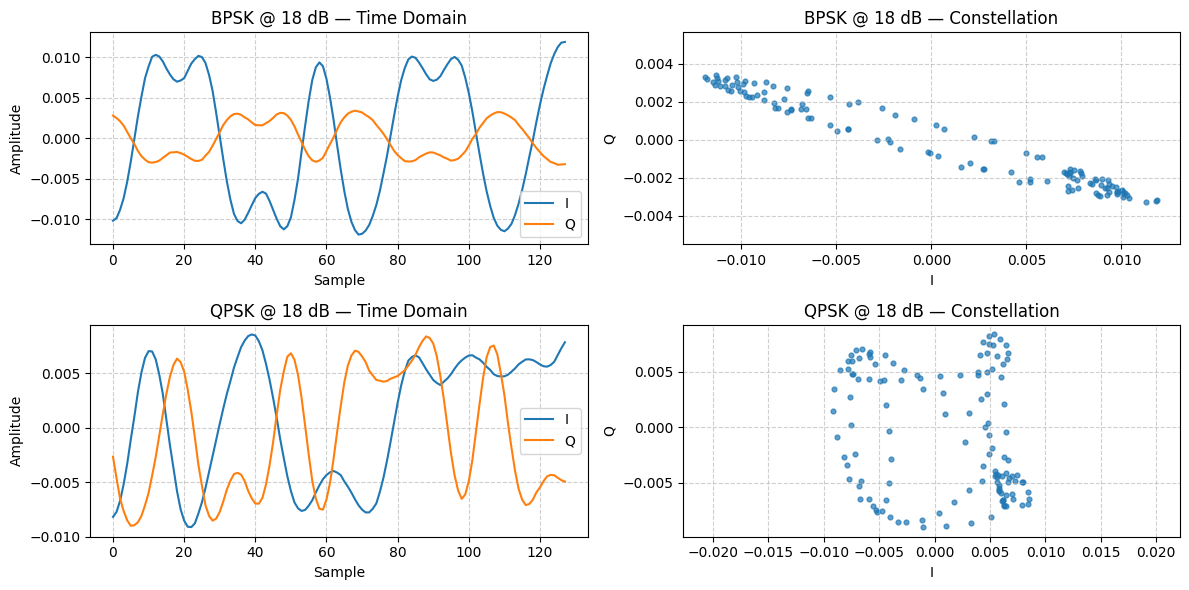

In [241]:
# Example usage: show analog mods for BPSK and QPSK at SNR=18 dB

fig, axs = visualize_modulations(radioml_data, mods=["BPSK","QPSK"], snr=18, seed=0)

In [242]:
ani = animate_bpsk_decision(
    radioml_data[('BPSK', 12)][0],
    key=('BPSK',12),
    gain=4.5,   # try 2–6
    sps=4       # 2–8 typical
)
display(HTML(ani.to_jshtml()))

## Data Preprocessing

**Goal.** Make the data ready for classical ML (flat features) and DL (tensor inputs), explain split policy, and document normalization choices.

- **Labels.** We classify **modulation only**; SNR is used purely for analysis (per-SNR accuracy).
- **Shapes.** Each sample is `(2, 128)` representing I/Q over 128 time points.
- **Splits.** Stratified by modulation label, fixed random seed for reproducibility.
- **Scaling.** Classical models (kNN/SVM/RF) benefit from standardization on flattened features.
- **DL format.** PyTorch CNN expects `(batch, channels=2, length=128)`; LSTM expects `(batch, seq_len=128, features=2)`.


In [243]:
# Split data into train and test sets
SEED = 42
X_train, X_test, y_train, y_test, snr_train, snr_test = train_test_split(
    X, y, snr_list, test_size=0.25, random_state=SEED, stratify=y
)
print("Train set size:", X_train.shape, "| Test set size:", X_test.shape)
print("Train label distribution:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Test label distribution:", dict(zip(*np.unique(y_test, return_counts=True))))


Train set size: (165000, 2, 128) | Test set size: (55000, 2, 128)
Train label distribution: {np.str_('8PSK'): np.int64(15000), np.str_('AM-DSB'): np.int64(15000), np.str_('AM-SSB'): np.int64(15000), np.str_('BPSK'): np.int64(15000), np.str_('CPFSK'): np.int64(15000), np.str_('GFSK'): np.int64(15000), np.str_('PAM4'): np.int64(15000), np.str_('QAM16'): np.int64(15000), np.str_('QAM64'): np.int64(15000), np.str_('QPSK'): np.int64(15000), np.str_('WBFM'): np.int64(15000)}
Test label distribution: {np.str_('8PSK'): np.int64(5000), np.str_('AM-DSB'): np.int64(5000), np.str_('AM-SSB'): np.int64(5000), np.str_('BPSK'): np.int64(5000), np.str_('CPFSK'): np.int64(5000), np.str_('GFSK'): np.int64(5000), np.str_('PAM4'): np.int64(5000), np.str_('QAM16'): np.int64(5000), np.str_('QAM64'): np.int64(5000), np.str_('QPSK'): np.int64(5000), np.str_('WBFM'): np.int64(5000)}


In [244]:
# Flatten the 2x256 I/Q matrices into 512-dim vectors for classical ML
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # shape (2250, 512)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)    # shape (750, 512)

# Standardize the features (zero mean, unit variance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)


In [245]:
# shapes
print('X:', X.shape, 'y:', y.shape, 'train:', X_train.shape, 'val:', X_test.shape)
print('num classes:', len(mod_classes), '->', NUM_CLASSES if 'NUM_CLASSES' in globals() else '(missing)')

# stratification sanity
ok = np.isclose((y_train==y_train[0]).mean(), (y==y[0]).mean(), atol=0.05)  # rough per-class ratio check
print('Stratified-ish:', ok)

# helper import sanity (should list your helper files)
import os, sys
print('src files:', os.listdir('../src') if os.path.exists('../src') else 'using cloned path ok')

X: (220000, 2, 128) y: (220000,) train: (165000, 2, 128) val: (55000, 2, 128)
num classes: 11 -> 11
Stratified-ish: True
src files: using cloned path ok


# Training Split Visualization
Visualize the distribution of modulation classes and SNR values in the training and testing sets to confirm that the split has adequately represented all classes and values.

## Prepare data for plotting

### Subtask:
Create pandas DataFrames for the training and testing sets, including columns for modulation classes and SNR values. This will make it easier to group and count the data.


**Reasoning**:
Create pandas DataFrames for the training and testing sets with 'modulation_class' and 'snr' columns.



In [246]:
train_df = pd.DataFrame({'modulation_class': y_train, 'snr': snr_train})
test_df = pd.DataFrame({'modulation_class': y_test, 'snr': snr_test})

## Calculate distributions

### Subtask:
Group the DataFrames by SNR and modulation class and count the occurrences in each group for both the training and testing sets.


**Reasoning**:
Group the training and testing DataFrames by 'snr' and 'modulation_class' to get the distribution of samples across these categories in each set.



In [250]:
train_distribution = train_df.groupby(['snr', 'modulation_class']).size().unstack(fill_value=0)
test_distribution = test_df.groupby(['snr', 'modulation_class']).size().unstack(fill_value=0)

print("Train Distribution:")
display(train_distribution.head())
print("\nTest Distribution:")
display(test_distribution.head())

Train Distribution:


modulation_class,8PSK,AM-DSB,AM-SSB,BPSK,CPFSK,GFSK,PAM4,QAM16,QAM64,QPSK,WBFM
snr,,,,,,,,,,,
-20,759,746,736,770,745,770,755,746,735,755,726
-18,749,714,738,759,730,766,767,770,755,748,732
-16,781,727,744,748,744,737,751,745,759,735,766
-14,749,756,720,757,744,751,767,739,775,753,752
-12,756,763,754,761,749,743,763,723,755,763,757



Test Distribution:


modulation_class,8PSK,AM-DSB,AM-SSB,BPSK,CPFSK,GFSK,PAM4,QAM16,QAM64,QPSK,WBFM
snr,,,,,,,,,,,
-20,241,254,264,230,255,230,245,254,265,245,274
-18,251,286,262,241,270,234,233,230,245,252,268
-16,219,273,256,252,256,263,249,255,241,265,234
-14,251,244,280,243,256,249,233,261,225,247,248
-12,244,237,246,239,251,257,237,277,245,237,243


## Visualize distributions

### Subtask:
Create bar plots or heatmaps to show the distribution of modulation classes across different SNR levels for both the training and testing sets.


**Reasoning**:
Create and display a heatmap for the training set distribution to visualize the counts of each modulation class across different SNR levels.



## Summary:

### Data Analysis Key Findings

*   The analysis successfully created heatmaps visualizing the distribution of modulation classes across different SNR levels for both the training and testing datasets.
*   These heatmaps visually demonstrate the frequency of each modulation class at various SNR levels within their respective datasets.

### Insights or Next Steps

*   Based on the visual analysis of the heatmaps, the data split appears to have adequately represented the distribution of modulation classes and SNR values in both the training and testing sets. This suggests the split is suitable for training and evaluating a model.


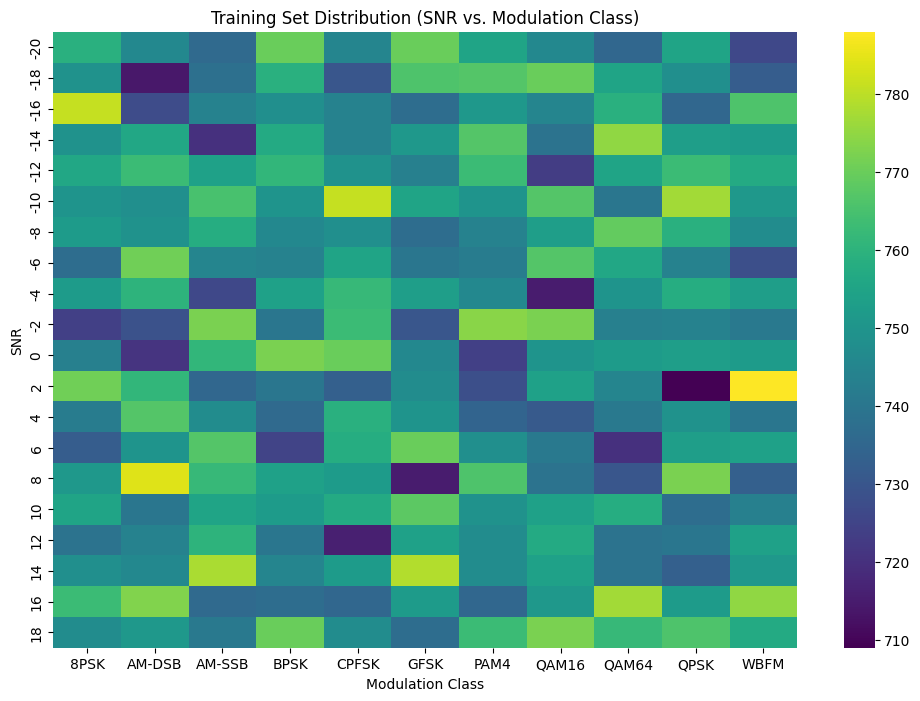

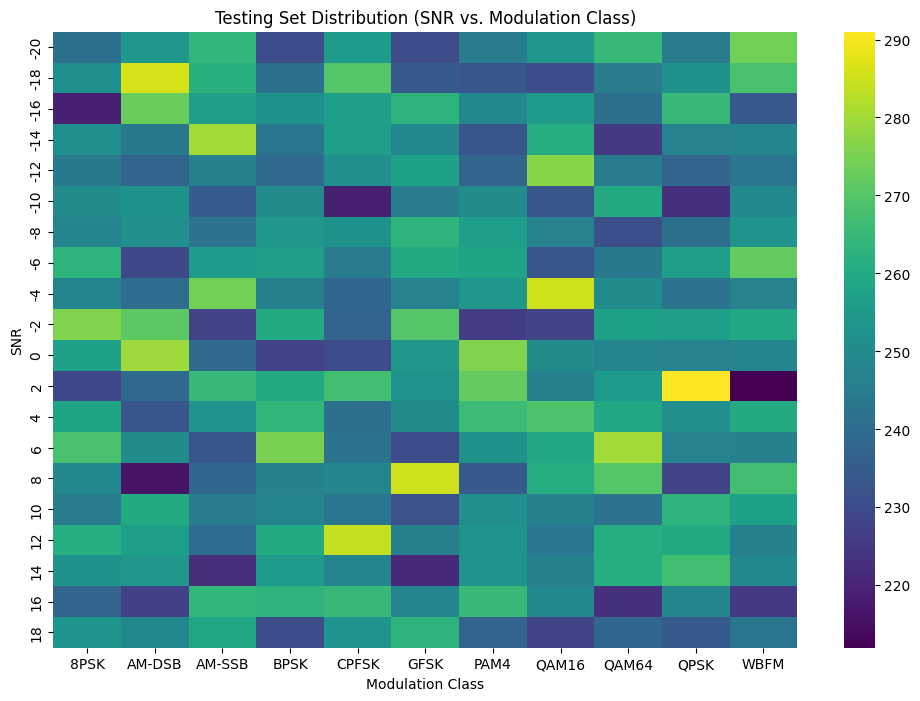

In [248]:
plt.figure(figsize=(12, 8))
sns.heatmap(train_distribution, annot=False, fmt="d", cmap="viridis")
plt.title("Training Set Distribution (SNR vs. Modulation Class)")
plt.xlabel("Modulation Class")
plt.ylabel("SNR")
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(test_distribution, annot=False, fmt="d", cmap="viridis")
plt.title("Testing Set Distribution (SNR vs. Modulation Class)")
plt.xlabel("Modulation Class")
plt.ylabel("SNR")
plt.show()

# Proceed to Notebook 2